In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression,Lasso,Ridge
from sklearn.metrics import mean_squared_error,r2_score


In [2]:
train = pd.read_csv('loan_data_train.csv')
test = pd.read_csv('loan_data_test.csv')

In [3]:
train.head()

,ID,Amount.Requested,Amount.Funded.By.Investors,Interest.Rate,Loan.Length,Loan.Purpose,Debt.To.Income.Ratio,State,Home.Ownership,Monthly.Income,FICO.Range,Open.CREDIT.Lines,Revolving.CREDIT.Balance,Inquiries.in.the.Last.6.Months,Employment.Length
0,79542.0,25000,25000,18.49%,60 months,debt_consolidation,27.56%,VA,MORTGAGE,8606.56,720-724,11,15210,3.0,5 years
1,75473.0,19750,19750,17.27%,60 months,debt_consolidation,13.39%,NY,MORTGAGE,6737.50,710-714,14,19070,3.0,4 years
2,67265.0,2100,2100,14.33%,36 months,major_purchase,3.50%,LA,OWN,1000.00,690-694,13,893,1.0,< 1 year
3,80167.0,28000,28000,16.29%,36 months,credit_card,19.62%,NV,MORTGAGE,7083.33,710-714,12,38194,1.0,10+ years
4,17240.0,24250,17431.82,12.23%,60 months,credit_card,23.79%,OH,MORTGAGE,5833.33,730-734,6,31061,2.0,10+ years


In [4]:
train.columns

Index(['ID', 'Amount.Requested', 'Amount.Funded.By.Investors', 'Interest.Rate',
       'Loan.Length', 'Loan.Purpose', 'Debt.To.Income.Ratio', 'State',
       'Home.Ownership', 'Monthly.Income', 'FICO.Range', 'Open.CREDIT.Lines',
       'Revolving.CREDIT.Balance', 'Inquiries.in.the.Last.6.Months',
       'Employment.Length'],
      dtype='object')

In [5]:
# Adding Interest.rate column to test data
test['Interest.Rate'] = np.nan 

# Adding data column to both train and test data to perform data preprocessing
train['data'] = 'Train' 
test['data'] = 'Test'


# Concating train and test dataframes
final = pd.concat([train,test],sort = True)

print(final['Interest.Rate'].head(2))
print(final['Debt.To.Income.Ratio'].head(2))

0    18.49%
1    17.27%
Name: Interest.Rate, dtype: object
0    27.56%
1    13.39%
Name: Debt.To.Income.Ratio, dtype: object


In [6]:
# Removing '%' symbol from columns
for cols in ['Debt.To.Income.Ratio','Interest.Rate']:
    final[cols] = final[cols].str.replace('%','')

# Converting columns to numeric type
for cols in ['Amount.Funded.By.Investors','Amount.Requested', 'Interest.Rate','Debt.To.Income.Ratio',
            'Open.CREDIT.Lines','Revolving.CREDIT.Balance']:
    final[cols]=pd.to_numeric(final[cols],errors='coerce')
    

final['FICO.Range'].head(2)

0    720-724
1    710-714
Name: FICO.Range, dtype: object

In [7]:
# Average of range of values are considered and deleting FicoRange column
k = final['FICO.Range'].str.split('-',expand=True).astype(int)
final['Fico'] = 0.5*k[0]*k[1]
del final['FICO.Range']

In [8]:
print('Before')
print(final['Employment.Length'].unique())

# Removing unneccessary strings and symbols
final['Employment.Length'] = final['Employment.Length'].str.replace('years','')
final['Employment.Length'] = final['Employment.Length'].str.replace('year','')
final['Employment.Length'] = np.where(final['Employment.Length'].str[0]=='<',0,final['Employment.Length'])
final['Employment.Length']=np.where(final['Employment.Length'].str[:2]=="10",10,final['Employment.Length'])
final['Employment.Length'] = pd.to_numeric(final['Employment.Length'],errors = 'coerce')
#Filling null values with mean of the column
final['Employment.Length'] = final['Employment.Length'].fillna(round(final['Employment.Length'].mean()))
print('After')
print(final['Employment.Length'].unique())

Before
['5 years' '4 years' '< 1 year' '10+ years' nan '2 years' '8 years'
 '1 year' '6 years' '7 years' '3 years' '9 years' '.']
After
[ 5.  4.  0. 10.  2.  8.  1.  6.  7.  3.  9.]


In [9]:
#Separating numerical and categorical features
num_var = [key for key in dict(final.dtypes) if dict(final.dtypes)[key] in ['int64','float64','int32','float32']]
cat_var = [key for key in dict(final.dtypes) if dict(final.dtypes)[key] in ['object']]

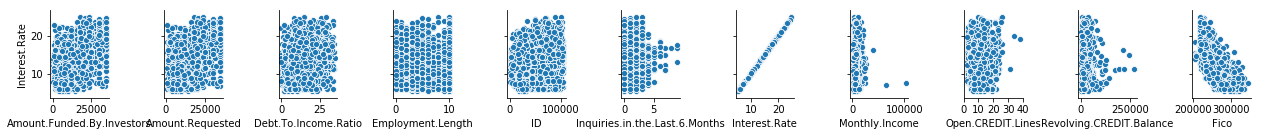

In [10]:
# Pair plot to check for linearity
sns.pairplot(x_vars = num_var,y_vars = 'Interest.Rate',data = final,height=2,aspect=0.8)
plt.show()

In [11]:
#Filling null values of cat_var with mode of their respective columns
final[cat_var] = final[cat_var].fillna(final[cat_var].mode().iloc[0])

# Converting categorical columns to numerical columns using one hot encoding
cat_var_dummies = pd.get_dummies(final[cat_var[:4]],drop_first=True)

#Dropping cat_var columns and concating one hotted columns to final
final = final.drop(cat_var[:4],axis = 1)
final = pd.concat([final,cat_var_dummies],axis = 1)

In [12]:
count=0
for i in final.isnull().sum(axis=1):
    if i>0:
        count=count+1
print('Total number of rows with missing values is ', count)
print('It is',round((count/len(final.index))*100), 'percent of the entire dataset.')

Total number of rows with missing values is  324
It is 13 percent of the entire dataset.


In [13]:
#As the null valued constitute 13% of whole data, we can drop them
final = final.dropna()

In [14]:
# Separting train and test data
train = final[final['data']=='Train'] 
test = final[final['data']=='Test'] 
test = test.drop('Interest.Rate',axis =1)
train = train.drop('data',axis = 1)
test = test.drop('data',axis = 1)

In [15]:
#Splitting full train into X(independent variables) and Y(dependent variables)
X = train.drop('Interest.Rate',axis = 1)
y = train['Interest.Rate']


In [16]:
# Linear Regression

In [17]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()

In [18]:
lr.fit(X,y)
base_ypred = lr.predict(X)

In [19]:
residuals = y.values-base_ypred
mean_res = np.mean(residuals)
mean_res

-1.6359462804035394e-15

In [20]:
xtrain,xval,ytrain,yval = train_test_split(X,y,test_size = 0.3,random_state=1)

In [21]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
xtrain_scaled = sc.fit_transform(xtrain)
xval_scaled = sc.transform(xval)

#Assumptions Of Linear Regression

## Goldfeld Quandt

In [22]:
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
name = ['F statistic', 'p-value']
test = sms.het_goldfeldquandt(residuals, X)
lzip(name, test)

[('F statistic', 0.8776009305320321), ('p-value', 0.9812182790372604)]

### Errors are homoscadastic

In [23]:
import matplotlib.pyplot as plt

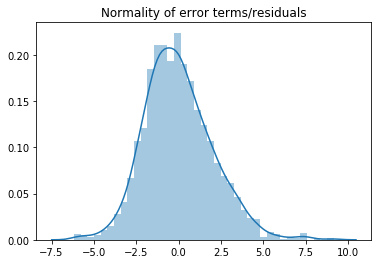

In [24]:
p = sns.distplot(residuals,kde=True)
p = plt.title('Normality of error terms/residuals')

### Errors are normal

## ljung box test

In [25]:
from statsmodels.stats import diagnostic as diag
min(diag.acorr_ljungbox(residuals , lags = 40)[1])

0.24585897873312285

### Autocorrelation is absent

In [26]:
import statsmodels.api as sm

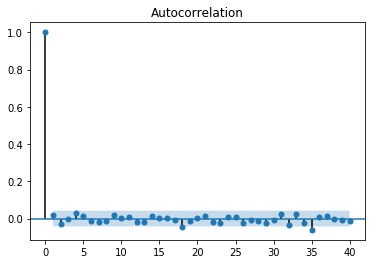

In [27]:
# autocorrelation
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()

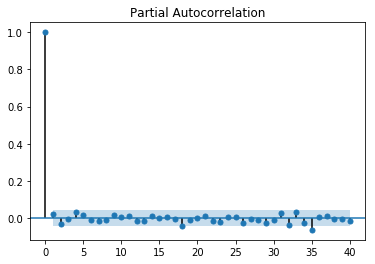

In [28]:
# partial autocorrelation
sm.graphics.tsa.plot_pacf(residuals, lags=40)
plt.show()

#Modeling

# Linear Reression 

In [29]:
lr.fit(xtrain_scaled,ytrain)
ypred = lr.predict(xtrain_scaled)

lr_ypred = lr.predict(xval_scaled)

print('TRAIN')
print('RMSE: ',np.sqrt(mean_squared_error(ytrain,ypred)))
print('R2 value: ',r2_score(ytrain,ypred)*100)
print('TEST')
print('RMSE: ',np.sqrt(mean_squared_error(yval,lr_ypred)))
print('R2 value: ',r2_score(yval,lr_ypred)*100)


TRAIN
RMSE:  2.006226351870615
R2 value:  76.02612329988574
TEST
RMSE:  2.121806654836906
R2 value:  76.03198259051538


# Ridge

In [30]:
lambdas = np.linspace(1,100,100)
params = {'alpha':lambdas}

from sklearn.linear_model import Ridge,Lasso

ridge = Ridge()
grid_search = GridSearchCV(ridge,param_grid=params,cv = 10)
grid_search.fit(xtrain_scaled,ytrain)

#print(grid_search.best_params_)

best_lr_ridge = grid_search.best_estimator_

best_lr_ridge.fit(xtrain_scaled,ytrain)
ypred = best_lr_ridge.predict(xtrain_scaled)
best_lr_ridge_ypred = best_lr_ridge.predict(xval_scaled)

print('TRAIN')
print('RMSE: ',np.sqrt(mean_squared_error(ytrain,ypred)))
print('R2 value: ',r2_score(ytrain,ypred)*100)
print('TEST')
print('RMSE: ',np.sqrt(mean_squared_error(yval,best_lr_ridge_ypred)))
print('R2 value: ',r2_score(yval,best_lr_ridge_ypred)*100)

TRAIN
RMSE:  2.0081167351725604
R2 value:  75.9809228491594
TEST
RMSE:  2.122392741187897
R2 value:  76.01873984956022


# Lasso

In [31]:
lasso= Lasso()
grid_search = GridSearchCV(lasso,param_grid=params,cv = 10)
grid_search.fit(xtrain_scaled,ytrain)
best_lr_lasso = grid_search.best_estimator_

best_lr_lasso.fit(xtrain_scaled,ytrain)
ypred = best_lr_lasso.predict(xtrain_scaled)
best_lr_lasso_ypred = best_lr_lasso.predict(xval_scaled)

print('TRAIN')
print('RMSE: ',np.sqrt(mean_squared_error(ytrain,ypred)))
print('R2 value: ',r2_score(ytrain,ypred)*100)
print('TEST')
print('RMSE: ',np.sqrt(mean_squared_error(yval,best_lr_lasso_ypred)))
print('R2 value: ',r2_score(yval,best_lr_lasso_ypred)*100)

TRAIN
RMSE:  2.6706194993253685
R2 value:  57.51824621889774
TEST
RMSE:  2.794577791738498
R2 value:  58.42302350703117


# Decision Tree

In [32]:
#Applying Random Forest
from sklearn.tree import DecisionTreeRegressor
dt = DecisionTreeRegressor()
dt.fit(xtrain_scaled,ytrain)
ypred = dt.predict(xtrain_scaled)
dt_ypred = dt.predict(xval_scaled)
print('TRAIN')
print('RMSE: ',np.sqrt(mean_squared_error(ytrain,ypred)))
print('R2 value: ',r2_score(ytrain,ypred)*100)
print('TEST')
print('RMSE: ',np.sqrt(mean_squared_error(yval,dt_ypred)))
print('R2 value: ',r2_score(yval,dt_ypred)*100)


TRAIN
RMSE:  4.1092168961745366e-16
R2 value:  100.0
TEST
RMSE:  2.368937155467482
R2 value:  70.12364739516745


# Random Forest

In [33]:
#Applying Random Forest
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=300)
rf.fit(xtrain_scaled,ytrain)
ypred = rf.predict(xtrain_scaled)
rf_ypred = rf.predict(xval_scaled)
print('TRAIN')
print('RMSE: ',np.sqrt(mean_squared_error(ytrain,ypred)))
print('R2 value: ',r2_score(ytrain,ypred)*100)
print('TEST')
print('RMSE: ',np.sqrt(mean_squared_error(yval,rf_ypred)))
print('R2 value: ',r2_score(yval,rf_ypred)*100)


TRAIN
RMSE:  0.6188236228361497
R2 value:  97.71906886085218
TEST
RMSE:  1.7244743187673575
R2 value:  84.16806641364106


# Random Forest with Hyper Parameter Tuning

In [34]:
params = {'n_estimators':[100,300,500],
          'max_features':[20,30,40],
          'min_samples_leaf':[10,15,20]
}

grid_search = GridSearchCV(rf,param_grid=params,cv = 5)
grid_search.fit(xtrain_scaled,ytrain)
grid_search.best_params_
best_rf = grid_search.best_estimator_
best_rf.fit(xtrain_scaled,ytrain)
ypred = best_rf.predict(xtrain_scaled)
best_rf_ypred = best_rf.predict(xval_scaled)
print('TRAIN')
print('RMSE: ',np.sqrt(mean_squared_error(ytrain,ypred)))
print('R2 value: ',r2_score(ytrain,ypred)*100)
print('TEST')
print('RMSE: ',np.sqrt(mean_squared_error(yval,best_rf_ypred)))
print('R2 value: ',r2_score(yval,best_rf_ypred)*100)

TRAIN
RMSE:  1.472529443729712
R2 value:  87.08464401722344
TEST
RMSE:  1.817339444374762
R2 value:  82.41701511710737


## Among all models 'Random Forest with Hyper Parameter Tuning' is choosen.

In [35]:
# df = pd.DataFrame({'ID':test.ID,'Interest.Rate':best_rf.predict(test)})
# df.to_csv('Submission_1.csv',index=False)